# Housing Price Index Prediction - BigData Final Project

# Importing all the required libraries to run models on data

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from graphviz import Source
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

### Creating a spark session to connect.

In [2]:
# Create a Spark session

spark = SparkSession.builder \
    .appName("HousingPricePrediction") \
    .config("spark.sql.catalogImplementation", "hive") \
    .getOrCreate()


In [3]:
spark

## Loading Housing Pricing Index data.

In [4]:
hpi = spark.read.csv("hpi.csv", header=True, inferSchema=True)

hpi.head(5)

[Row(hpi_type='traditional', hpi_flavor='purchase-only', frequency='monthly', level='USA or Census Division', place_name='East North Central Division', place_id='DV_ENC', yr=2010, period=1, index_nsa=162.9, index_sa=165.07),
 Row(hpi_type='traditional', hpi_flavor='purchase-only', frequency='monthly', level='USA or Census Division', place_name='East North Central Division', place_id='DV_ENC', yr=2010, period=2, index_nsa=162.46, index_sa=164.35),
 Row(hpi_type='traditional', hpi_flavor='purchase-only', frequency='monthly', level='USA or Census Division', place_name='East North Central Division', place_id='DV_ENC', yr=2010, period=3, index_nsa=163.2, index_sa=164.46),
 Row(hpi_type='traditional', hpi_flavor='purchase-only', frequency='monthly', level='USA or Census Division', place_name='East North Central Division', place_id='DV_ENC', yr=2010, period=4, index_nsa=165.12, index_sa=164.5),
 Row(hpi_type='traditional', hpi_flavor='purchase-only', frequency='monthly', level='USA or Census 

In [5]:
hpi.createOrReplaceTempView("hpi_tmp_view")

In [6]:
# Executing Spark SQL query to select all columns from the 'hpi_tmp_view' into DataFrame
df = spark.sql("SELECT * FROM hpi_tmp_view")
df.show(5)


+-----------+-------------+---------+--------------------+--------------------+--------+----+------+---------+--------+
|   hpi_type|   hpi_flavor|frequency|               level|          place_name|place_id|  yr|period|index_nsa|index_sa|
+-----------+-------------+---------+--------------------+--------------------+--------+----+------+---------+--------+
|traditional|purchase-only|  monthly|USA or Census Div...|East North Centra...|  DV_ENC|2010|     1|    162.9|  165.07|
|traditional|purchase-only|  monthly|USA or Census Div...|East North Centra...|  DV_ENC|2010|     2|   162.46|  164.35|
|traditional|purchase-only|  monthly|USA or Census Div...|East North Centra...|  DV_ENC|2010|     3|    163.2|  164.46|
|traditional|purchase-only|  monthly|USA or Census Div...|East North Centra...|  DV_ENC|2010|     4|   165.12|   164.5|
|traditional|purchase-only|  monthly|USA or Census Div...|East North Centra...|  DV_ENC|2010|     5|   168.12|  164.71|
+-----------+-------------+---------+---

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

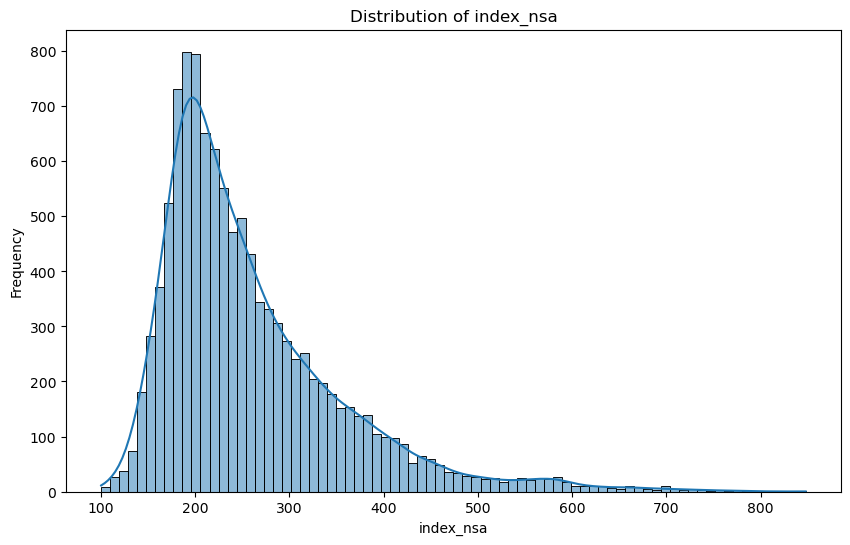

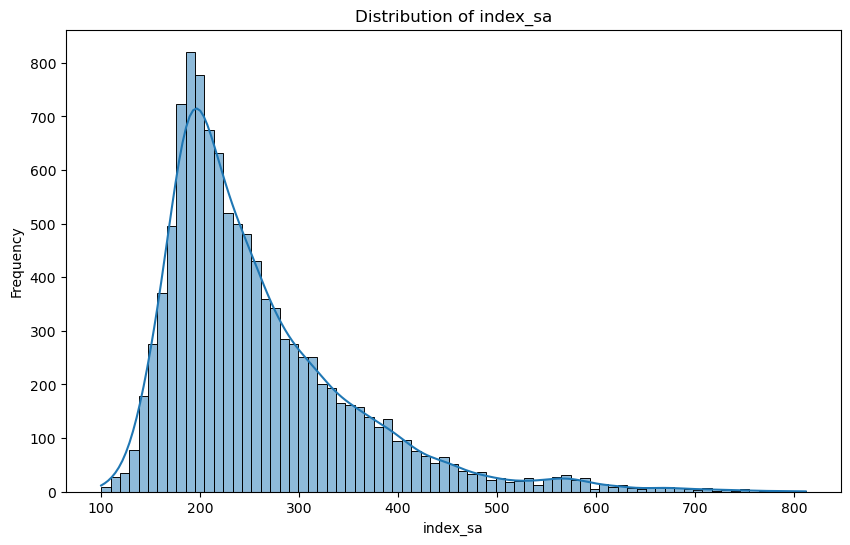

In [8]:
# Select columns for visualization
selected_columns = ['index_nsa', 'index_sa']
pandas_df = hpi.select(selected_columns).toPandas()

# Plot histograms for selected columns
for column in selected_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(pandas_df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

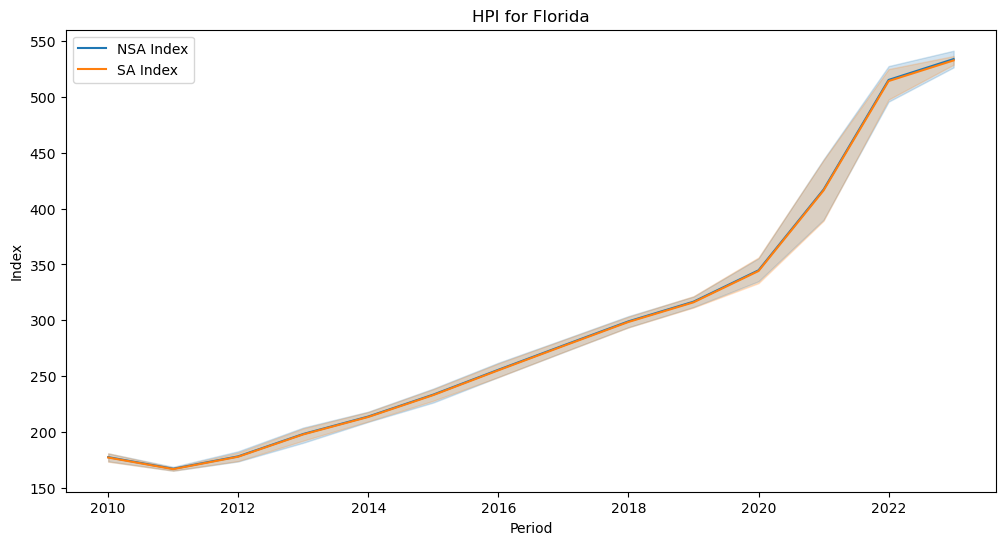

In [86]:
florida_data = hpi.filter(col("place_name") == "Florida")

# Convert Spark DataFrame to Pandas DataFrame for plotting
florida_data_pandas = florida_data.toPandas()

# Plot the line graph for Florida
plt.figure(figsize=(12, 6))
sns.lineplot(x="yr", y="index_nsa", data=florida_data_pandas, label="NSA Index")
sns.lineplot(x="yr", y="index_sa", data=florida_data_pandas, label="SA Index")
plt.title("HPI for Florida")
plt.xlabel("Period")
plt.ylabel("Index")
plt.legend()
plt.show()

In [9]:
# Executing a Spark SQL query to count the occurrences of values in the 'hpi_type' column from the 'hpi_tmp_view' DataFrame
df = spark.sql("SELECT COUNT(hpi_type) FROM hpi_tmp_view")
df.show(5)


+---------------+
|count(hpi_type)|
+---------------+
|          11036|
+---------------+



In [12]:
type(hpi)

pyspark.sql.dataframe.DataFrame

## Creating a database in Spark Session 

In [ ]:
hpi.printSchema()

In [11]:
# average index values by year
spark.sql("""
    SELECT
        yr AS Year,
        AVG(index_nsa) AS Avg_Non_Seasonal_Index,
        AVG(index_sa) AS Avg_Seasonal_Index
    FROM
        hpi_tmp_view
    GROUP BY
        yr
    ORDER BY
        yr
""").show()

+----+----------------------+------------------+
|Year|Avg_Non_Seasonal_Index|Avg_Seasonal_Index|
+----+----------------------+------------------+
|2010|     190.4586397058823|189.68763480392133|
|2011|    182.32604166666675|181.59455882352955|
|2012|    187.54932598039215|186.79105392156856|
|2013|    201.51224264705866| 200.6986397058821|
|2014|    211.52142156862718|210.67669117647043|
|2015|    223.14555147058826| 222.2448651960784|
|2016|    236.16019607843182|235.19988970588244|
|2017|     251.0427696078435|250.01428921568606|
|2018|    266.87605392156877|265.78128676470607|
|2019|     280.2484313725492|  279.104632352941|
|2020|      302.794975490196| 301.6034558823533|
|2021|    354.44191176470565|  353.017781862745|
|2022|     402.7908088235295| 401.0860171568625|
|2023|     413.1331775700938| 409.7160280373834|
+----+----------------------+------------------+



In [12]:
# top places with maximum index values
spark.sql("""
    SELECT
        place_name AS Place_Name,
        MAX(index_nsa) AS Max_Non_Seasonal_Index,
        MAX(index_sa) AS Max_Seasonal_Index
    FROM
        hpi_tmp_view
    GROUP BY
        place_name
    ORDER BY
        Max_Non_Seasonal_Index DESC
""").show()

+--------------------+----------------------+------------------+
|          Place_Name|Max_Non_Seasonal_Index|Max_Seasonal_Index|
+--------------------+----------------------+------------------+
|Austin-Round Rock...|                847.83|            811.62|
|  Salt Lake City, UT|                806.61|            789.48|
|Denver-Aurora-Lak...|                765.96|            745.92|
|      Boise City, ID|                755.22|            724.13|
|                Utah|                726.97|            712.34|
|Miami-Miami Beach...|                709.58|            702.71|
|            Colorado|                704.04|            686.53|
|             Montana|                700.05|            683.84|
|District of Columbia|                662.33|            646.42|
|Portland-Vancouve...|                657.32|            641.44|
|               Idaho|                645.35|            630.84|
|              Oregon|                634.75|            622.35|
|Phoenix-Mesa-Chan...|   

In [13]:
#monthly trend for a specific place namely the state of florida
spark.sql("""
    SELECT
        yr AS Year,
        period AS Month,
        AVG(index_nsa) AS Avg_Non_Seasonal_Index,
        AVG(index_sa) AS Avg_Seasonal_Index
    FROM
        hpi_tmp_view
    WHERE
        place_name = 'Florida'
    GROUP BY
        yr, period
    ORDER BY
        yr, period
""").show()

+----+-----+----------------------+------------------+
|Year|Month|Avg_Non_Seasonal_Index|Avg_Seasonal_Index|
+----+-----+----------------------+------------------+
|2010|    1|                181.74|            182.57|
|2010|    2|                180.03|            179.17|
|2010|    3|                176.56|            175.11|
|2010|    4|                 171.6|            171.72|
|2011|    1|                164.32|            165.22|
|2011|    2|                166.35|             165.5|
|2011|    3|                168.98|            167.48|
|2011|    4|                168.62|             168.8|
|2012|    1|                170.98|             172.0|
|2012|    2|                177.12|            176.15|
|2012|    3|                181.59|            179.95|
|2012|    4|                183.14|            183.34|
|2013|    1|                188.25|            189.37|
|2013|    2|                196.62|            195.51|
|2013|    3|                202.55|            200.79|
|2013|    

In [14]:
#Comparison of Index Values Across Regions:
spark.sql("""
    SELECT
        place_name AS Place_Name,
        MAX(index_nsa) AS Max_Non_Seasonal_Index,
        MAX(index_sa) AS Max_Seasonal_Index,
        AVG(index_nsa) AS Avg_Non_Seasonal_Index,
        AVG(index_sa) AS Avg_Seasonal_Index
    FROM
        hpi_tmp_view
    GROUP BY
        place_name
    ORDER BY
        Avg_Non_Seasonal_Index DESC
""").show()

+--------------------+----------------------+------------------+----------------------+------------------+
|          Place_Name|Max_Non_Seasonal_Index|Max_Seasonal_Index|Avg_Non_Seasonal_Index|Avg_Seasonal_Index|
+--------------------+----------------------+------------------+----------------------+------------------+
|District of Columbia|                662.33|            646.42|    474.20500000000004|468.93648148148156|
|Denver-Aurora-Lak...|                765.96|            745.92|     441.6355555555555| 439.0485185185185|
|  Salt Lake City, UT|                806.61|            789.48|     437.0211111111111|435.48833333333323|
|Austin-Round Rock...|                847.83|            811.62|    436.09814814814814|435.26055555555564|
|            Colorado|                704.04|            686.53|    410.05055555555555|407.96500000000003|
|Portland-Vancouve...|                657.32|            641.44|     405.5177777777778|403.27962962962954|
|             Montana|               

In [15]:
#Yearly Percentage Change in Index Values
spark.sql("""
    SELECT
        yr AS Year,
        (MAX(index_nsa) - LAG(MAX(index_nsa), 1) OVER (ORDER BY yr)) / LAG(MAX(index_nsa), 1) OVER (ORDER BY yr) * 100 AS Percentage_Change
    FROM
        hpi_tmp_view
    GROUP BY
        yr
    ORDER BY
        yr
""").show()

+----+-------------------+
|Year|  Percentage_Change|
+----+-------------------+
|2010|               NULL|
|2011| 3.1983340067758563|
|2012|  7.351966748991033|
|2013| 14.361866285105068|
|2014|  3.856533045483531|
|2015|   8.22270515424954|
|2016| 4.2649787187602355|
|2017|  5.913877200695011|
|2018| 6.7695774202474714|
|2019|  4.448434809974263|
|2020| 3.6014320655063514|
|2021| 24.126663701372035|
|2022| 16.850200531995533|
|2023|-10.414823726454603|
+----+-------------------+



# Running ML models on the loaded data

## LINEAR REGRESSION MODEL

In [16]:
hpi.printSchema()

root
 |-- hpi_type: string (nullable = true)
 |-- hpi_flavor: string (nullable = true)
 |-- frequency: string (nullable = true)
 |-- level: string (nullable = true)
 |-- place_name: string (nullable = true)
 |-- place_id: string (nullable = true)
 |-- yr: integer (nullable = true)
 |-- period: integer (nullable = true)
 |-- index_nsa: double (nullable = true)
 |-- index_sa: double (nullable = true)



## identify the columns

In [17]:
categorical_columns = ['hpi_type', 'hpi_flavor', 'frequency', 'level', 'place_name', 'place_id']
numeric_columns = ['yr', 'period']
label_columns = ['index_nsa', 'index_sa']

## Creating indexers

In [18]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid='keep') for col in categorical_columns]


## Creating assembler

In [19]:
assembler = VectorAssembler(
    inputCols=numeric_columns + [col+"_index" for col in categorical_columns],
    outputCol="features"
)

## FEATURE ENGINEERING(RATIO of index_nsa and index_sa)

In [20]:
hpi = hpi.withColumn("index_ratio", col("index_nsa") / col("index_sa"))

In [21]:
# Adding this new columns (feature engineered) to numerical columns
numeric_columns_f = numeric_columns + ["index_ratio"]

## New assembler with the feature engineering column

In [22]:
assembler_new = VectorAssembler(
    inputCols=[col+"_index" for col in categorical_columns] + numeric_columns_f,
    outputCol="features"
)

# Fitting the model

# linear regression for index_nsa

# Split the data

In [23]:
train_data, test_data = hpi.randomSplit([0.8, 0.2])

# Fitting the model

In [24]:
# Create a Linear Regression model for index_nsa
lr_nsa = LinearRegression(featuresCol="features", labelCol="index_nsa")

In [25]:
# A pipeline with StringIndexers for categorical columns and the new assembler and train the data
pipeline_nsa = Pipeline(stages=indexers + [assembler_new, lr_nsa])
fitted_pipeline_nsa = pipeline_nsa.fit(train_data)

In [26]:
transformed_data_nsa = fitted_pipeline_nsa.transform(test_data)

In [27]:
print("Transformed Data for index_nsa:")
transformed_data_nsa.show()

Transformed Data for index_nsa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0.0|            0

# Root mean squared error

In [28]:
# Create a RegressionEvaluator to evaluate the Linear Regression model on 'index_nsa' and evaluate on test data
evaluator_nsa = RegressionEvaluator(labelCol="index_nsa", predictionCol="prediction", metricName="rmse")
rmse_nsa = evaluator_nsa.evaluate(transformed_data_nsa)
print("Root Mean Squared Error (RMSE) on test data for index_nsa = %g" % rmse_nsa)

Root Mean Squared Error (RMSE) on test data for index_nsa = 73.1683


# Linear regression for index_sa

In [29]:
# Create a Linear Regression model for index_sa
lr_sa = LinearRegression(featuresCol="features", labelCol="index_sa")

In [30]:
#  A pipeline with StringIndexers for categorical columns and the new assembler and to train and test the data
pipeline_sa = Pipeline(stages=indexers + [assembler_new, lr_sa])
fitted_pipeline_sa = pipeline_sa.fit(train_data)

In [31]:
transformed_data_sa = fitted_pipeline_sa.transform(test_data)

In [32]:
print("Transformed Data for index_sa:")
transformed_data_sa.show()

Transformed Data for index_sa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0.0|            0.

# Root mean squared error

In [33]:
# Create a RegressionEvaluator to evaluate the performance of the model on index_sa
evaluator_sa = RegressionEvaluator(labelCol="index_sa", predictionCol="prediction", metricName="rmse")
# Using the evaluator to calculate the Root Mean Squared Error (RMSE) on the test data
rmse_sa = evaluator_sa.evaluate(transformed_data_sa)
print("Root Mean Squared Error (RMSE) on test data for index_sa = %g" % rmse_sa)

Root Mean Squared Error (RMSE) on test data for index_sa = 72.7341


# Decision tree model for index_nsa

In [34]:
# Create a DecisionTreeRegressor model for index_nsa with maxBins set to 164
dt_nsa = DecisionTreeRegressor(featuresCol="features", labelCol="index_nsa", maxBins=164)

In [35]:
# Create a pipeline with StringIndexers, VectorAssembler, and DecisionTreeRegressor and train the data
pipeline_dt_nsa = Pipeline(stages=indexers + [assembler_new, dt_nsa])
fitted_pipeline_dt_nsa = pipeline_dt_nsa.fit(train_data)

In [36]:
transformed_data_dt_nsa = fitted_pipeline_dt_nsa.transform(test_data)

# Print the transformed data

In [37]:
print("Transformed Data for Decision Tree - index_nsa:")
transformed_data_dt_nsa.show()

Transformed Data for Decision Tree - index_nsa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0

# Root mean squared error

In [38]:
# Evaluating the DecisionTreeRegressor model for index_nsa using regression evaluator
evaluator_nsa = RegressionEvaluator(labelCol="index_nsa", predictionCol="prediction", metricName="rmse")
rmse_dt_nsa = evaluator_nsa.evaluate(transformed_data_dt_nsa)
print("Root Mean Squared Error (RMSE) on test data for Decision Tree - index_nsa = %g" % rmse_dt_nsa)

Root Mean Squared Error (RMSE) on test data for Decision Tree - index_nsa = 23.1503


# Decision tree feature importance for index_nsa

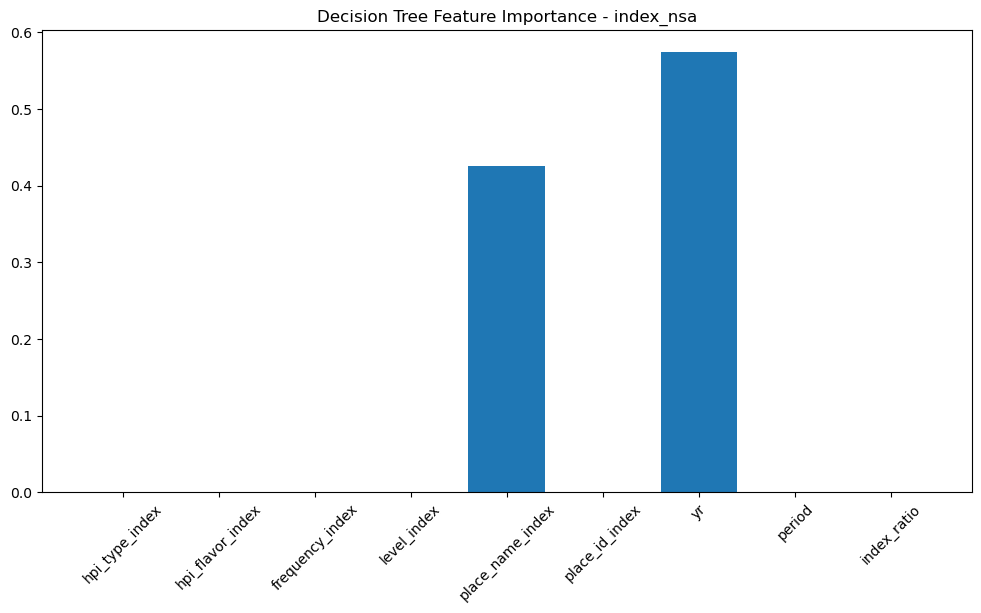

In [39]:
# Visualize the DecisionTreeRegressor feature importance for index_nsa
feature_importances_nsa = fitted_pipeline_dt_nsa.stages[-1].featureImportances.toArray()
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances_nsa)), feature_importances_nsa)
plt.xticks(range(len(feature_importances_nsa)), assembler_new.getInputCols(), rotation=45)
plt.title("Decision Tree Feature Importance - index_nsa")
plt.show()

# Decision tree rules for index_nsa

In [40]:
print("Decision Tree Rules for index_nsa:")
print(fitted_pipeline_dt_nsa.stages[-1].toDebugString)

Decision Tree Rules for index_nsa:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_da9a0453b167, depth=5, numNodes=63, numFeatures=9
  If (feature 6 <= 2019.5)
   If (feature 4 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,9.0,10.0,11.0,14.0,15.0,20.0,21.0,22.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,33.0,35.0,36.0,37.0,38.0,39.0,42.0,43.0,44.0,45.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,57.0,60.0,61.0,62.0,63.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,73.0,74.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,91.0,92.0,93.0,96.0,98.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,114.0,115.0,116.0,118.0,119.0,120.0,121.0,122.0,125.0,126.0,128.0,130.0,131.0,132.0,133.0,134.0,135.0,136.0,137.0,140.0,141.0,142.0,143.0,145.0,146.0,147.0,148.0,149.0,153.0,154.0,155.0,157.0,159.0,160.0,161.0})
    If (feature 6 <= 2015.5)
     If (feature 4 in {2.0,10.0,11.0,21.0,24.0,29.0,31.0,33.0,38.0,39.0,42.0,45.0,47.0,48.0,49.0,60.0,61.0,62.0,63.0,65.0,66.0,

# Decision tree model for index_sa

In [41]:
# Decision Tree model for index_sa with maxBins specified
dt_sa = DecisionTreeRegressor(featuresCol="features", labelCol="index_sa", maxBins=164)

In [42]:
# Creating a pipeline for Decision Tree model for index_sa and fit the pipline to train the data
pipeline_dt_sa = Pipeline(stages=indexers + [assembler_new, dt_sa])
fitted_pipeline_dt_sa = pipeline_dt_sa.fit(train_data)

In [43]:
transformed_data_dt_sa = fitted_pipeline_dt_sa.transform(test_data)

# Print the transformed data

In [44]:
print("Transformed Data for Decision Tree - index_sa:")
transformed_data_dt_sa.show()

Transformed Data for Decision Tree - index_sa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0.

# Root mean squared error for index_sa

In [45]:
# Create a RegressionEvaluator for evaluating the Decision Tree model for index_sa
evaluator_sa = RegressionEvaluator(labelCol="index_sa", predictionCol="prediction", metricName="rmse")

# Use the evaluator to calculate the RMSE on the test data
rmse_dt_sa = evaluator_sa.evaluate(transformed_data_dt_sa)

print("Root Mean Squared Error (RMSE) on test data for Decision Tree - index_sa = %g" % rmse_dt_sa)


Root Mean Squared Error (RMSE) on test data for Decision Tree - index_sa = 23.0431


# Decision tree feature importance for index_sa

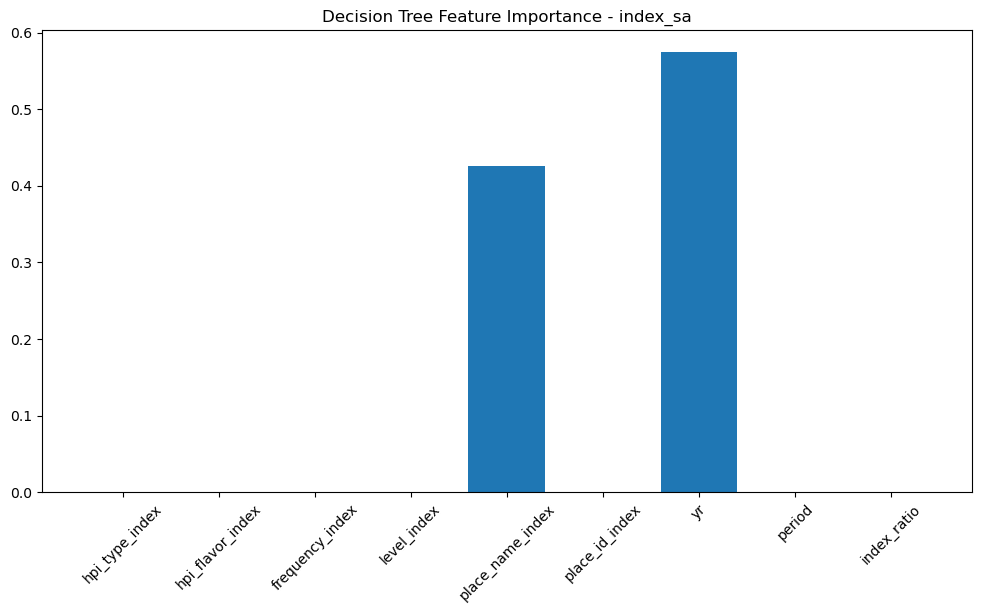

In [46]:
# Extract feature importances from the Decision Tree model for index_sa
feature_importances_sa = fitted_pipeline_dt_sa.stages[-1].featureImportances.toArray()

# Plot the feature importances using Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances_sa)), feature_importances_sa)
plt.xticks(range(len(feature_importances_sa)), assembler_new.getInputCols(), rotation=45)
plt.title("Decision Tree Feature Importance - index_sa")
plt.show()


# Decision tree rules for index_sa

In [47]:
print("Decision Tree Rules for index_sa:")
print(fitted_pipeline_dt_sa.stages[-1].toDebugString)

Decision Tree Rules for index_sa:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2175aa1d7dcf, depth=5, numNodes=63, numFeatures=9
  If (feature 6 <= 2019.5)
   If (feature 4 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,9.0,10.0,11.0,14.0,15.0,20.0,21.0,22.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,33.0,35.0,36.0,37.0,38.0,39.0,42.0,43.0,44.0,45.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,57.0,60.0,61.0,62.0,63.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,73.0,74.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,91.0,92.0,93.0,96.0,98.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,114.0,115.0,116.0,118.0,119.0,120.0,121.0,122.0,125.0,126.0,128.0,130.0,131.0,132.0,133.0,134.0,135.0,136.0,137.0,140.0,141.0,142.0,143.0,145.0,146.0,147.0,148.0,149.0,153.0,154.0,155.0,157.0,159.0,160.0,161.0})
    If (feature 6 <= 2015.5)
     If (feature 4 in {2.0,10.0,11.0,21.0,24.0,29.0,31.0,33.0,38.0,39.0,42.0,45.0,47.0,48.0,49.0,60.0,61.0,62.0,63.0,65.0,66.0,6

# Random forest model for index_nsa

In [48]:
# RandomForest model for index_nsa with maxBins specified
rf_nsa = RandomForestRegressor(featuresCol="features", labelCol="index_nsa", maxBins=164)

In [49]:
# Define a pipeline with stages: StringIndexers, VectorAssembler, and RandomForest and fit the model
pipeline_rf_nsa = Pipeline(stages=indexers + [assembler_new, rf_nsa])
fitted_pipeline_rf_nsa = pipeline_rf_nsa.fit(train_data)

In [50]:
# Transform the test data using the fitted pipeline
transformed_data_rf_nsa = fitted_pipeline_rf_nsa.transform(test_data)

In [51]:
print("Transformed Data for Random Forest - index_nsa:")
transformed_data_rf_nsa.show()


Transformed Data for Random Forest - index_nsa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0

# Root mean squared error for index_sa

In [52]:
# Create a RegressionEvaluator for the 'index_nsa' column, with the RMSE metric and evaluting the model
evaluator_nsa = RegressionEvaluator(labelCol="index_nsa", predictionCol="prediction", metricName="rmse")
rmse_rf_nsa = evaluator_nsa.evaluate(transformed_data_rf_nsa)
print("Root Mean Squared Error (RMSE) on test data for Random Forest - index_nsa = %g" % rmse_rf_nsa)

Root Mean Squared Error (RMSE) on test data for Random Forest - index_nsa = 33.1065


# Random forest for index_sa

In [53]:
# Create a RandomForestRegressor model for predicting 'index_sa' column
rf_sa = RandomForestRegressor(featuresCol="features", labelCol="index_sa", maxBins=164)

In [54]:
# Create a pipeline for RandomForestRegressor model to fit the data to tein the model
pipeline_rf_sa = Pipeline(stages=indexers + [assembler_new, rf_sa])
fitted_pipeline_rf_sa = pipeline_rf_sa.fit(train_data)

In [55]:
transformed_data_rf_sa = fitted_pipeline_rf_sa.transform(test_data)

In [56]:
print("Transformed Data for Random Forest - index_sa:")
transformed_data_rf_sa.show()

Transformed Data for Random Forest - index_sa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0.

# Root mean squared error for index_sa

In [57]:
# Create a RegressionEvaluator to evaluate the RandomForestRegressor model on 'index_sa'
evaluator_sa = RegressionEvaluator(labelCol="index_sa", predictionCol="prediction", metricName="rmse")

# Use the evaluator to calculate the RMSE on the test data
rmse_rf_sa = evaluator_sa.evaluate(transformed_data_rf_sa)

# Print the RMSE on the test data for the RandomForestRegressor model predicting 'index_sa'
print("Root Mean Squared Error (RMSE) on test data for Random Forest - index_sa = %g" % rmse_rf_sa)


Root Mean Squared Error (RMSE) on test data for Random Forest - index_sa = 33.1336


## GBT regressor

In [58]:
# GBT model for index_nsa
gbt_nsa = GBTRegressor(featuresCol="features", labelCol="index_nsa", maxIter=10, maxBins=164)
pipeline_gbt_nsa = Pipeline(stages=indexers + [assembler_new, gbt_nsa])
fitted_pipeline_gbt_nsa = pipeline_gbt_nsa.fit(train_data)
transformed_data_gbt_nsa = fitted_pipeline_gbt_nsa.transform(test_data)

In [59]:
# GBT model for index_sa
gbt_sa = GBTRegressor(featuresCol="features", labelCol="index_sa", maxIter=10, maxBins=164)
pipeline_gbt_sa = Pipeline(stages=indexers + [assembler_new, gbt_sa])
fitted_pipeline_gbt_sa = pipeline_gbt_sa.fit(train_data)
transformed_data_gbt_sa = fitted_pipeline_gbt_sa.transform(test_data)

In [60]:
# Show the transformed data for index_nsa
print("Transformed Data for GBT - index_nsa:")
transformed_data_gbt_nsa.show()

Transformed Data for GBT - index_nsa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0.0|       

In [61]:
# Show the transformed data for index_sa
print("Transformed Data for GBT - index_sa:")
transformed_data_gbt_sa.show()

Transformed Data for GBT - index_sa:
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|     hpi_type|   hpi_flavor|frequency|      level|          place_name|place_id|  yr|period|index_nsa|index_sa|       index_ratio|hpi_type_index|hpi_flavor_index|frequency_index|level_index|place_name_index|place_id_index|            features|        prediction|
+-------------+-------------+---------+-----------+--------------------+--------+----+------+---------+--------+------------------+--------------+----------------+---------------+-----------+----------------+--------------+--------------------+------------------+
|developmental|purchase-only|quarterly|Puerto Rico|         Puerto Rico|      PR|2010|     2|   189.34|  187.95|1.0073955839318969|           2.0|             0.0|        

In [62]:
# Evaluate the models using regression evaluators
evaluator_nsa = RegressionEvaluator(labelCol="index_nsa", predictionCol="prediction", metricName="rmse")
rmse_gbt_nsa = evaluator_nsa.evaluate(transformed_data_gbt_nsa)
print("Root Mean Squared Error (RMSE) on test data for GBT - index_nsa = %g" % rmse_gbt_nsa)

Root Mean Squared Error (RMSE) on test data for GBT - index_nsa = 17.2674


In [63]:
# Create a RegressionEvaluator to evaluate the GBTRegressor model on 'index_sa'
evaluator_sa = RegressionEvaluator(labelCol="index_sa", predictionCol="prediction", metricName="rmse")

# Use the evaluator to calculate the RMSE on the test data
rmse_gbt_sa = evaluator_sa.evaluate(transformed_data_gbt_sa)

# Print the RMSE on the test data for the GBTRegressor model predicting 'index_sa'
print("Root Mean Squared Error (RMSE) on test data for GBT - index_sa = %g" % rmse_gbt_sa)


Root Mean Squared Error (RMSE) on test data for GBT - index_sa = 16.4879


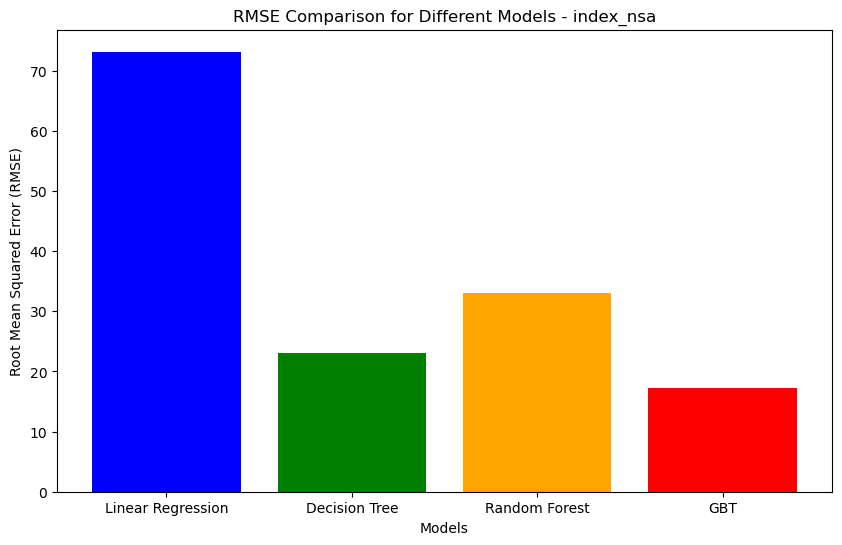

In [65]:
import matplotlib.pyplot as plt

rmse_values = [rmse_nsa, rmse_dt_nsa, rmse_rf_nsa, rmse_gbt_nsa]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'GBT']

plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_values, color=['blue', 'green', 'orange', 'red'])  # Add color for GBT
plt.title('RMSE Comparison for Different Models - index_nsa')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()


In [69]:
print(rmse_nsa, rmse_dt_nsa, rmse_rf_nsa, rmse_gbt_nsa)

73.16826527563529 23.150308243457218 33.10652679424802 17.267379771078534


In [71]:
print(rmse_sa, rmse_dt_sa, rmse_rf_sa, rmse_gbt_sa)

72.73406786246811 23.043127713975338 33.13359369960135 16.487906309201843


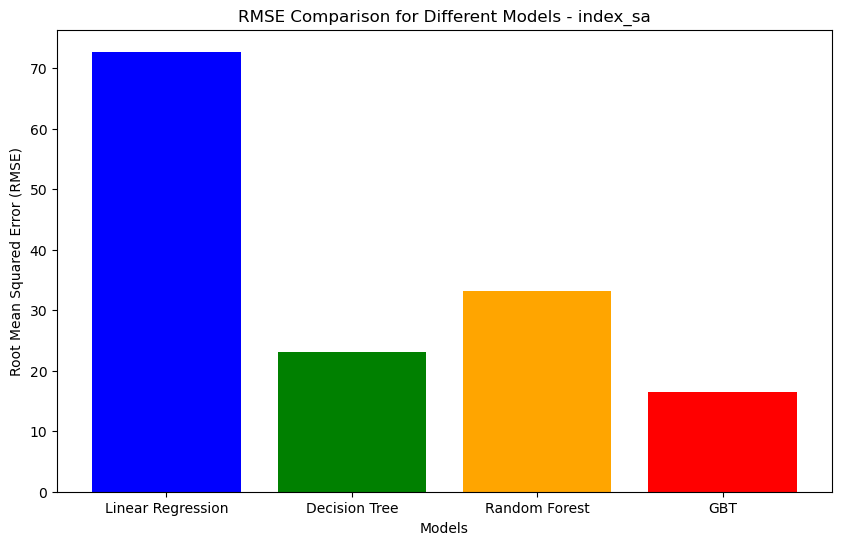

In [68]:
import matplotlib.pyplot as plt

rmse_values = [rmse_sa, rmse_dt_sa, rmse_rf_sa, rmse_gbt_sa]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'GBT']

plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_values, color=['blue', 'green', 'orange', 'red'])  # Add color for GBT
plt.title('RMSE Comparison for Different Models - index_sa')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()
